In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import seaborn as sns
from cycler import cycler
from IPython.display import display
import datetime
import scipy.stats
import warnings
from colorama import Fore, Back, Style
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibrationDisplay
from lightgbm import LGBMClassifier, log_evaluation

plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
plt.rcParams['text.color'] = 'w'

INFERENCE = True

In [2]:
def amex_metric(y_true, y_pred, return_components=False) -> float:
    def top_four_percent_captured(df) -> float:
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(df) -> float:
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(df) -> float:
        """Corresponds to 2 * AUC - 1"""
        df2 = pd.DataFrame({'target': df.target, 'prediction': df.target})
        df2.sort_values('prediction', ascending=False, inplace=True)
        return weighted_gini(df) / weighted_gini(df2)

    df = pd.DataFrame({'target': y_true.ravel(), 'prediction': y_pred.ravel()})
    df.sort_values('prediction', ascending=False, inplace=True)
    g = normalized_weighted_gini(df)
    d = top_four_percent_captured(df)

    if return_components: return g, d, 0.5 * (g + d)
    return 0.5 * (g + d)

def lgb_amex_metric(y_true, y_pred):
    """The competition metric with lightgbm's calling convention"""
    return ('amex',
            amex_metric(y_true, y_pred),
            True)

In [3]:
features_avg = ['B_1', 'B_11', 'B_16', 'B_17', 'B_18', 'B_2', 'B_20',
                'B_28', 'B_3', 'B_4', 'B_5', 'B_7', 'B_9', 'D_112',
                'D_121', 'D_141', 'D_39', 'D_41', 'D_42', 'D_43',
                'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 
                'D_50', 'D_51', 'D_53', 'D_54', 'D_56', 'D_58', 
                'D_59', 'D_60', 'D_91', 'P_2', 'P_3', 'R_1', 'R_2', 
                'R_27', 'R_3', 'R_7', 'S_11', 'S_26', 'S_3', 'S_5']
features_last = ['B_1', 'B_10', 'B_11', 'B_12', 'B_13', 'B_15', 'B_16',
                 'B_17', 'B_18', 'B_19', 'B_2', 'B_20', 'B_22', 'B_23',
                 'B_24', 'B_25', 'B_26', 'B_27', 'B_28', 'B_29', 'B_3',
                 'B_32', 'B_33', 'B_36', 'B_38', 'B_39', 'B_4', 'B_40',
                 'B_41', 'B_42', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9',
                 'D_102', 'D_103', 'D_105', 'D_106', 'D_107', 'D_109',
                 'D_112', 'D_115', 'D_117', 'D_118', 'D_119', 'D_120',
                 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_127', 
                 'D_129', 'D_132', 'D_133', 'D_135', 'D_136', 'D_137', 
                 'D_140', 'D_141', 'D_143', 'D_145', 'D_39', 'D_41',
                 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48',
                 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55',
                 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63',
                 'D_64', 'D_66', 'D_70', 'D_72', 'D_73', 'D_74', 'D_75',
                 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_82', 'D_83',
                 'D_84', 'D_86', 'D_91', 'D_92', 'D_93', 'D_94', 'D_96',
                 'P_2', 'P_3', 'R_1', 'R_10', 'R_11', 'R_12', 'R_13',
                 'R_14', 'R_15', 'R_17', 'R_18', 'R_19', 'R_2', 'R_20', 
                 'R_21', 'R_22', 'R_24', 'R_25', 'R_26', 'R_27', 'R_3',
                 'R_4', 'R_5', 'R_7', 'R_8', 'R_9', 'S_11', 'S_12',
                 'S_13', 'S_15', 'S_17', 'S_20', 'S_22', 'S_23', 
                 'S_24', 'S_25', 'S_26', 'S_27', 'S_3', 'S_5', 'S_6',
                 'S_7', 'S_8', 'S_9']

In [4]:
train_data = pd.read_feather('data/train_data.ftr')
cid = pd.Categorical(train_data.pop('customer_ID'), ordered=True)
last = (cid != np.roll(cid, -1))
target = train_data.loc[last, 'target']
df_avg = train_data[features_avg].groupby(cid).mean().rename(columns={f: f"{f}_avg" for f in features_avg})
train_data = train_data.loc[last, features_last].rename(columns={f: f"{f}_last" for f in features_last}).set_index(np.asarray(cid[last]))
train_data = pd.concat([train_data, df_avg], axis=1)

In [5]:
test_data = pd.read_feather('data/test_data.ftr')
cid = pd.Categorical(test_data.pop('customer_ID'), ordered=True)
last = (cid != np.roll(cid, -1))
df_avg = test_data[features_avg].groupby(cid).mean().rename(columns={f: f"{f}_avg" for f in features_avg})
test_data = test_data.loc[last, features_last].rename(columns={f: f"{f}_last" for f in features_last}).set_index(np.asarray(cid[last]))
test_data = pd.concat([test_data, df_avg], axis=1)

In [6]:
def my_booster(random_state=1, n_estimators=195):
    return LGBMClassifier(n_estimators=n_estimators,
                          min_child_samples=2400,
                          num_leaves=127,
                          max_bins=511, random_state=random_state)

ONLY_FIRST_FOLD = False

features = [f for f in train_data.columns if f not in ('customer_ID', 'target')]

score_list = []
y_pred_list = []
kf = StratifiedKFold(n_splits=5, random_state=777)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train_data, target)):
    start_time = datetime.datetime.now()
    X_tr = train_data.iloc[idx_tr][features]
    X_va = train_data.iloc[idx_va][features]
    y_tr = target.iloc[idx_tr]
    y_va = target.iloc[idx_va]
    
    model = my_booster()
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(X_tr, y_tr,
                  eval_set = [(X_tr, y_tr),(X_va, y_va)], 
                  eval_metric=[lgb_amex_metric],
                  callbacks=[log_evaluation(30)])

    y_va_pred = model.predict_proba(X_va)[:,1]
    score = amex_metric(y_va.values, y_va_pred)
    n_trees = model.best_iteration_
    if n_trees is None: n_trees = model.n_estimators
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f" {n_trees:5} trees |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)
    
    if INFERENCE:
        y_pred_list.append(model.predict_proba(test_data[features])[:,1])
        
    if ONLY_FIRST_FOLD: break # we only want the first fold
    
print(f"{Fore.GREEN}{Style.BRIGHT}OOF Score:                       {np.mean(score_list):.5f}{Style.RESET_ALL}")

[30]	training's binary_logloss: 0.235636	training's amex: 0.778379	valid_1's binary_logloss: 0.243834	valid_1's amex: 0.765462
[60]	training's binary_logloss: 0.211728	training's amex: 0.802818	valid_1's binary_logloss: 0.22814	valid_1's amex: 0.778946
[90]	training's binary_logloss: 0.19906	training's amex: 0.820521	valid_1's binary_logloss: 0.224675	valid_1's amex: 0.783412
[120]	training's binary_logloss: 0.188842	training's amex: 0.834168	valid_1's binary_logloss: 0.223526	valid_1's amex: 0.786636
[150]	training's binary_logloss: 0.179636	training's amex: 0.848769	valid_1's binary_logloss: 0.22316	valid_1's amex: 0.787384
[180]	training's binary_logloss: 0.1712	training's amex: 0.862635	valid_1's binary_logloss: 0.223193	valid_1's amex: 0.787345
Fold 0 | 02:21 |   195 trees |                Score = 0.78714
[30]	training's binary_logloss: 0.235965	training's amex: 0.779918	valid_1's binary_logloss: 0.242866	valid_1's amex: 0.761418
[60]	training's binary_logloss: 0.212001	training's

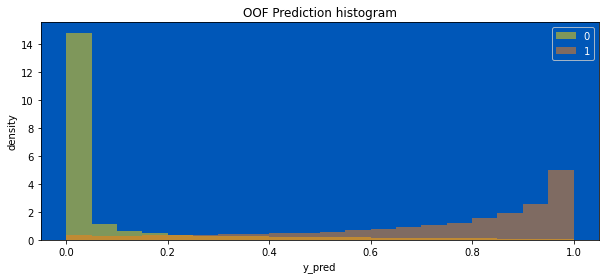

In [7]:
plt.figure(figsize=(10, 4))
plt.hist(y_va_pred[y_va == 0], bins=np.linspace(0, 1, 21),
         alpha=0.5, density=True, label='0')
plt.hist(y_va_pred[y_va == 1], bins=np.linspace(0, 1, 21),
         alpha=0.5, density=True, label='1')
plt.xlabel('y_pred')
plt.ylabel('density')
plt.title('OOF Prediction histogram', color='k')
plt.legend()
plt.show()

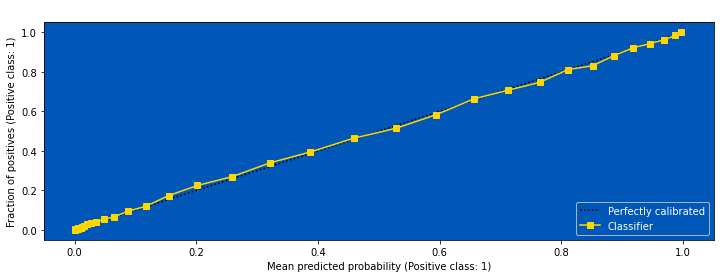

In [8]:
plt.figure(figsize=(12, 4))
CalibrationDisplay.from_predictions(y_va, y_va_pred, n_bins=50, strategy='quantile', ax=plt.gca())
plt.title('Probability calibration')
plt.show()

In [10]:
if INFERENCE:
    sub = pd.DataFrame({'customer_ID': test_data.index,
                        'prediction': np.mean(y_pred_list, axis=0)})
    sub.to_csv('submission.csv', index=False)
    display(sub)

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,0.018513
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,0.000825
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,0.031678
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,0.271779
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,0.908023
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,0.014191
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,0.779236
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,0.445475
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,0.344342
